Task 5a.

To estimate the robot's position and orientation in a global coordinate system, we can use the distances to two QR-codes and the angle to one of them.

Position Estimation: Knowing the distances from the robot to two QR-codes with known global coordinates allows us to determine the robot's position in the 2D plane. These two distances create two circles centered on each QR-code, and the intersection of these circles yields two possible locations for the robot.

Orientation Estimation: To resolve the ambiguity in position and determine the robot's orientation, we need an angle measurement (relative bearing) to one of the QR-codes. This angle provides a directional constraint, allowing us to identify the correct position among the two intersections and calculate the robot's orientation.

Therefore, to uniquely determine the robot's position and attitude in the global coordinate system, we need a minimum of two QR-codes: two distances and one angle.

Task 5b.

- The wall/frame dimension is 121.5 (cm) x 121.5 (cm).
- The qr code dimension is 11.5 (cm) x 11.5 (cm).
- Focal Length (in pixels): 524.7239977877415



So the QR-CODE positions of WALL2 are:

QR13:(13, 121.5)
QR14:(25, 121.5)
QR15:(37, 121.5)
QR1:(50.5, 121.5)
QR2:(62.5, 121.5)
QR3:(74.5, 121.5)
QR9:(86.5, 121.5)
QR8:(98, 121.5)
QR7:(111, 121.5)

Jacobian of the Measurement Model:
The Jacobian matrix reflects how changes in the robot's position (𝑝𝑥,𝑝𝑦)and orientation (𝜓)affect observed QR code height and horizontal position in the camera. For height, it includes derivatives with respect to 𝑝𝑥 and 𝑝𝑦, while for horizontal position, it includes derivatives with respect to 𝑝𝑥, 𝑝𝑦, and 𝜓.
Measurement Variance Matrix:
Assuming measurement noise of 5 pixels in both height and horizontal position, we set up a diagonal measurement variance matrix with values of 25. This matrix weights measurements, giving less influence to those with greater uncertainty, enhancing the accuracy of the robot’s estimated position and orientation.

QR Global Positions (Wall 2):
QR Code 13.0: Position (13.0, 121.5)
QR Code 14.0: Position (25.0, 121.5)
QR Code 15.0: Position (37.0, 121.5)
QR Code 1.0: Position (50.5, 121.5)
QR Code 2.0: Position (62.5, 121.5)
QR Code 3.0: Position (74.5, 121.5)
QR Code 9.0: Position (86.5, 121.5)
QR Code 8.0: Position (98.0, 121.5)
QR Code 7.0: Position (111.0, 121.5)

Measurement Variance Matrix:
[[25  0]
 [ 0 25]]

Estimated Position: (62.69858786950529, 23.75072322959173)
Estimated Heading (psi): 1.5738873519504075

Jacobian Matrix at Estimated Position and Heading:
[[-1.49219352e-02 -1.23596088e-01  0.00000000e+00]
 [ 1.05818780e+00 -1.27756549e-01 -1.06555016e+02]
 [ 2.56606783e-04 -1.26307450e-01  0.00000000e+00]
 ...
 [ 1.05714831e+00  1.31926465e-01 -1.06498020e+02]
 [ 4.54864650e-02 -8.94646959e-02  0.00000000e+00]
 [ 8.53088443e-01  4.33735086e-01 -1.31660168e+02]]


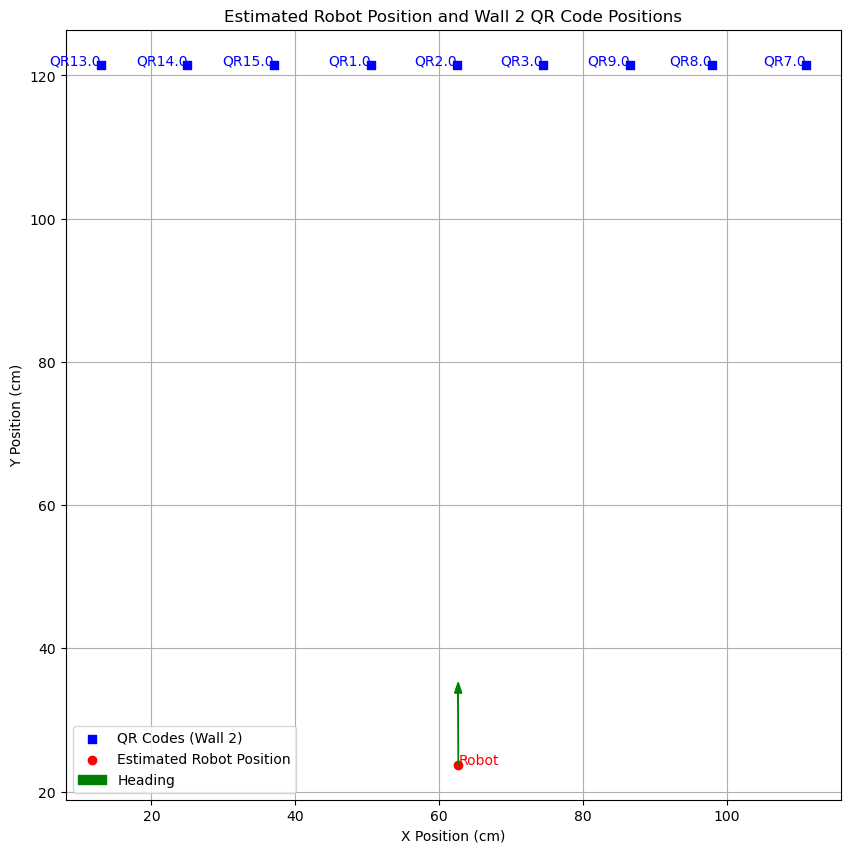

In [19]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# Known parameters
focal_length = 524.7239977877415  # Focal length in pixels
qr_code_height_real = 11.5  # Real-world height of the QR code in cm

# Load QR code global coordinates from the file
qr_code_file = './qr_code_position_in_global_coordinate.csv'
qr_data = pd.read_csv(qr_code_file)

# Remove any extra spaces in column names
qr_data.columns = qr_data.columns.str.strip()

# Filter only QR codes on Wall 2
wall2_qr_data = qr_data[qr_data['position_in_wall'] == 2]

# Create a dictionary of QR codes {qr_code: (x, y)} for Wall 2
qr_global_positions = {
    row['qr_code']: (row['mid_point_x_cm'], row['mid_point_y_cm'])
    for _, row in wall2_qr_data.iterrows()
}

# Print the QR code coordinates for Wall 2
print("QR Global Positions (Wall 2):")
for qr_id, position in qr_global_positions.items():
    print(f"QR Code {qr_id}: Position {position}")

# Load camera data with comma as a delimiter
file_path = './camera_loxalization_task5.csv'
data = pd.read_csv(file_path, sep=r'\s*,\s*', header=None, engine='python')
data.columns = ["timestamp", "qr_id", "Cx", "Cy", "width_px", "height_px", "distance_measured", "angle_measured"]

# Extract relevant QR data from the camera log
qr_data = data[["qr_id", "Cx", "Cy", "width_px", "height_px", "distance_measured", "angle_measured"]].values.tolist()

# Define measurement noise covariance and standard deviation
measurement_variance = np.diag([5**2, 5**2])  # Assumed measurement noise of 5 pixels for height and horizontal position
measurement_std = np.sqrt(np.diag(measurement_variance))  # Standard deviation

print("\nMeasurement Variance Matrix:")
print(measurement_variance)

# Define the measurement model function
def measurement_model(x, qr_data, qr_global_positions):
    """Compute the residuals for the measurement model."""
    p_x, p_y, psi = x
    residuals = []

    for qr_id, Cx_obs, Cy_obs, width_px, height_px_obs, distance_measured, angle_measured in qr_data:
        if qr_id in qr_global_positions:
            s_x, s_y = qr_global_positions[qr_id]
            d_pred = np.sqrt((s_x - p_x)**2 + (s_y - p_y)**2)
            h_pred = qr_code_height_real * focal_length / d_pred
            phi_pred = np.arctan2(s_y - p_y, s_x - p_x) - psi
            Cx_pred = focal_length * np.tan(phi_pred)

            # Weighted residuals for height and horizontal position
            residual_h = (h_pred - height_px_obs) / measurement_std[0]
            residual_Cx = (Cx_pred - Cx_obs) / measurement_std[1]

            residuals.extend([residual_h, residual_Cx])

    return residuals

# Define the Jacobian computation function
def jacobian(x, qr_data, qr_global_positions):
    """Compute the Jacobian matrix for the measurement model."""
    p_x, p_y, psi = x
    J = []

    for qr_id, Cx_obs, Cy_obs, width_px, height_px_obs, distance_measured, angle_measured in qr_data:
        if qr_id in qr_global_positions:
            s_x, s_y = qr_global_positions[qr_id]
            delta_x = s_x - p_x
            delta_y = s_y - p_y
            d_pred = np.sqrt(delta_x**2 + delta_y**2)
            phi_pred = np.arctan2(delta_y, delta_x) - psi

            # Partial derivatives for h_i
            dh_dx = -qr_code_height_real * focal_length * delta_x / (d_pred**3) / measurement_std[0]
            dh_dy = -qr_code_height_real * focal_length * delta_y / (d_pred**3) / measurement_std[0]
            dh_dpsi = 0

            # Partial derivatives for Cx_i
            dCx_dx = focal_length * delta_y / (d_pred**2) / measurement_std[1]
            dCx_dy = -focal_length * delta_x / (d_pred**2) / measurement_std[1]
            dCx_dpsi = -focal_length / (np.cos(phi_pred)**2) / measurement_std[1]

            J.append([dh_dx, dh_dy, dh_dpsi])
            J.append([dCx_dx, dCx_dy, dCx_dpsi])

    return np.array(J)

# Initial guess for position and heading [p_x, p_y, psi]
initial_guess = [0, 0, 0]

# Solve the nonlinear least squares problem
result = least_squares(
    measurement_model,
    initial_guess,
    args=(qr_data, qr_global_positions),
    jac=jacobian
)

# Extract the estimated position and heading
p_x, p_y, psi = result.x
print("\nEstimated Position:", (p_x, p_y))
print("Estimated Heading (psi):", psi)

# Compute the Jacobian matrix at the final estimated position
jacobian_matrix = jacobian(result.x, qr_data, qr_global_positions)
print("\nJacobian Matrix at Estimated Position and Heading:")
print(jacobian_matrix)

# Visualization: Plot QR codes and estimated robot position
plt.figure(figsize=(10, 10))

# Plot QR code positions
qr_x = [pos[0] for pos in qr_global_positions.values()]
qr_y = [pos[1] for pos in qr_global_positions.values()]
plt.scatter(qr_x, qr_y, c='blue', marker='s', label='QR Codes (Wall 2)')
for qr_id, (x, y) in qr_global_positions.items():
    plt.text(x, y, f'QR{qr_id}', ha='right', color='blue')

# Plot estimated robot position
plt.scatter(p_x, p_y, c='red', marker='o', label='Estimated Robot Position')
plt.text(p_x, p_y, 'Robot', ha='left', color='red')
plt.arrow(p_x, p_y,10 * np.cos(psi),10* np.sin(psi), head_width=1, color='green', label='Heading')

# Configure plot settings
plt.xlabel("X Position (cm)")
plt.ylabel("Y Position (cm)")
plt.title("Estimated Robot Position and Wall 2 QR Code Positions")
plt.legend()
plt.grid()
plt.show()


The robot's estimated position is approximately 62 point 69 centimeters in x and 23 point 75 centimeters in y, with an orientation of 1 point 57 radians. This estimate was obtained using nonlinear weighted least squares with QR code measurements. A variance matrix assuming 5 pixel noise in each measurement set values of 25 for both height and horizontal position, reducing the impact of less reliable data. The Jacobian matrix at this position helps the model adjust the estimate by showing how x, y, and orientation changes affect the measurements.

Task6

Synchronized data structure:
      timestamp  input_1  input_2  velocity     acc_x     acc_y     acc_z  \
0  1.635752e+09     0.30      0.0  0.934603  0.071614 -0.011102  1.016260   
1  1.635752e+09     0.30      0.3  1.869206  0.045506  0.026352  1.020652   
2  1.635752e+09     0.18      0.3  1.495365  0.049044 -0.020740  1.012478   
3  1.635752e+09     0.18      0.3  1.495365  0.051484  0.000732  1.001742   
4  1.635752e+09     0.30      0.3  1.869206  0.047458  0.021472  1.024678   

       roll     pitch   gyro_x   gyro_y     gyro_z     mag_x     mag_y  \
0  0.050418 -1.485305  1.36808  0.04179 -15.867408 -0.711926 -1.125110   
1  3.077303 -0.037350  0.59808 -0.41321  -0.852407 -0.698918 -1.071324   
2 -0.497895  0.372081 -0.41692 -0.69321   6.182593 -0.698480 -1.102748   
3  0.716578 -0.396775 -0.20692 -0.41321   5.832592 -0.695557 -1.123794   
4  2.467695 -0.531217 -0.20692 -0.13321   1.177593 -0.709588 -1.173926   

      mag_z  
0 -0.457176  
1 -0.472376  
2 -0.469746  
3 -0.45

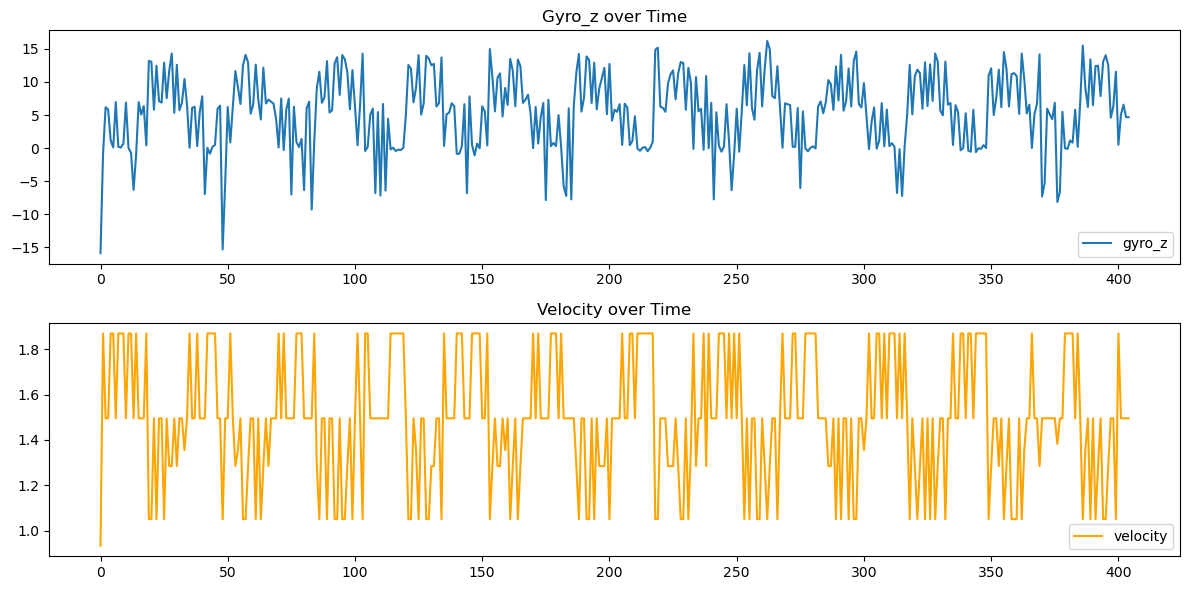

Calculated INITIAL_DT: 0.501916780330167


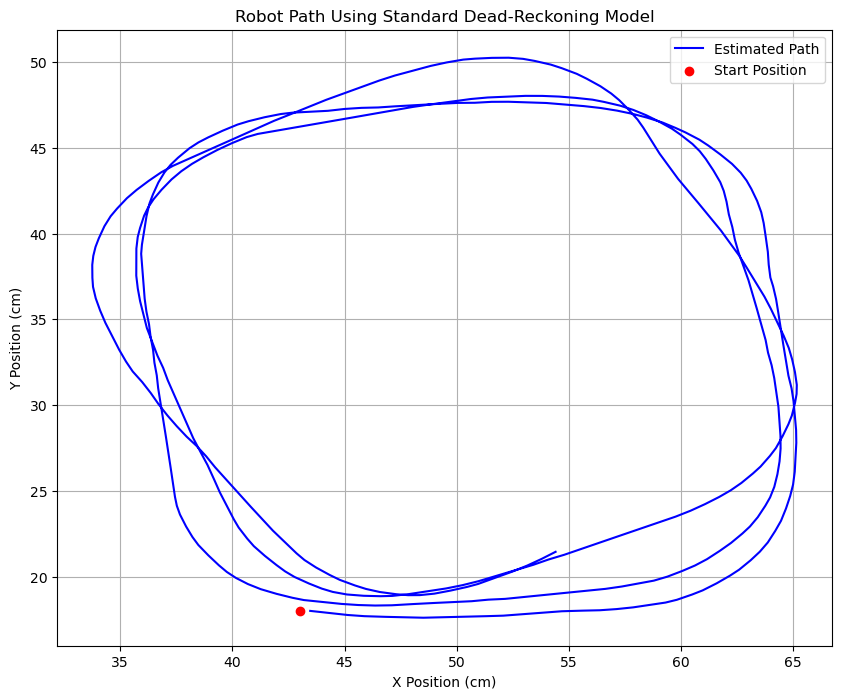

Final Position (X, Y): (54.4081576943475, 21.444880596961124)
Final Heading (Degrees): 35.921597221787366


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load IMU data
imu_columns = ['timestamp', 'acc_x', 'acc_y', 'acc_z', 'roll', 'pitch', 
               'gyro_x', 'gyro_y', 'gyro_z', 'mag_x', 'mag_y', 'mag_z']
imu_data = pd.read_csv('./imu_tracking_task6.csv', header=None, names=imu_columns)

# Load PWM data
pwm_columns = ['timestamp', 'input_1', 'input_2']
motor_data = pd.read_csv('./motor_control_tracking_task6.csv', header=None, names=pwm_columns)

# Calibrate velocity
FULL_VELOCITY = 6.230687410530891  # Calibrated velocity (cm/s)
motor_data['velocity'] = (motor_data['input_1'] * FULL_VELOCITY + motor_data['input_2'] * FULL_VELOCITY) / 2

# Synchronize IMU and PWM data using merge_asof
df_imu_motor = pd.merge_asof(motor_data, imu_data, on='timestamp', direction='backward')

# Check the structure of the synchronized data
print("Synchronized data structure:")
print(df_imu_motor.head())

# Plot gyro_z and velocity
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df_imu_motor['gyro_z'], label='gyro_z')
plt.title('Gyro_z over Time')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df_imu_motor['velocity'], label='velocity', color='orange')
plt.title('Velocity over Time')
plt.legend()
plt.tight_layout()
plt.show()

# Dead-Reckoning: Using Euler method
# Initialization
INITIAL_X = 43
INITIAL_Y = 18
INITIAL_PSI = 0  # Initial heading (degrees)

time_intervals = np.diff(df_imu_motor['timestamp'])
INITIAL_DT = np.mean(time_intervals)
print("Calculated INITIAL_DT:", INITIAL_DT)

px, py, psi = INITIAL_X, INITIAL_Y, INITIAL_PSI
p_x, p_y, p_psi = [], [], []

# Dead-Reckoning loop
for _, row in df_imu_motor.iterrows():
    # Update position
    dp_x = row['velocity'] * np.cos(np.deg2rad(psi)) * INITIAL_DT
    dp_y = row['velocity'] * np.sin(np.deg2rad(psi)) * INITIAL_DT
    dpsi = row['gyro_z'] * INITIAL_DT

    px += dp_x
    py += dp_y
    psi = (psi + dpsi) % 360  # Restrict angle range to [0, 360]

    # Save results
    p_x.append(px)
    p_y.append(py)
    p_psi.append(psi)

# Plot the trajectory
plt.figure(figsize=(10, 8))
plt.plot(p_x, p_y, label="Estimated Path", color="blue")
plt.scatter([INITIAL_X], [INITIAL_Y], color="red", label="Start Position")
plt.xlabel("X Position (cm)")
plt.ylabel("Y Position (cm)")
plt.title("Robot Path Using Standard Dead-Reckoning Model")
plt.legend()
plt.grid(True)
plt.show()

# Output final position and heading
print("Final Position (X, Y):", (p_x[-1], p_y[-1]))
print("Final Heading (Degrees):", p_psi[-1])


Task7

In [21]:
# Function to calculate dist_sigma and phi_sigma
def compute_noise_statistics(qr_data, qr_global_positions, p_x, p_y, psi):
    distance_errors = []
    angle_errors = []

    # Iterate through each QR code data entry
    for qr_id, Cx_obs, Cy_obs, width_px, height_px_obs, distance_measured, angle_measured in qr_data:
        # Check if QR code ID is in the global positions map
        if qr_id in qr_global_positions:
            s_x, s_y = qr_global_positions[qr_id]
            
            # Calculate predicted distance and angle
            d_pred = np.sqrt((s_x - p_x)**2 + (s_y - p_y)**2)
            phi_pred = np.arctan2(s_y - p_y, s_x - p_x) - psi
            phi_pred = np.degrees(phi_pred)  # Convert to degrees

            # Compute errors
            distance_errors.append(distance_measured - d_pred)
            angle_errors.append(angle_measured - phi_pred)

    # Calculate standard deviations
    dist_sigma = np.std(distance_errors)
    phi_sigma = np.std(angle_errors)

    return dist_sigma, phi_sigma

# Calculate noise statistics using the estimated robot position and orientation
dist_sigma, phi_sigma = compute_noise_statistics(qr_data, qr_global_positions, p_x, p_y, psi)

print("Estimated dist_sigma (Distance Noise Std):", dist_sigma)
print("Estimated phi_sigma (Angle Noise Std):", phi_sigma)


Estimated dist_sigma (Distance Noise Std): 12.883957892639001
Estimated phi_sigma (Angle Noise Std): 6.743859598060579


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# File paths
imu_file = './imu_tracking_task6.csv'
motor_file = './motor_control_tracking_task6.csv'
camera_file = './camera_tracking_task6.csv'
qr_code_file = './qr_code_position_in_global_coordinate.csv'

# Load IMU data
imu_columns = ['timestamp', 'acc_x', 'acc_y', 'acc_z', 'roll', 'pitch', 
               'gyro_x', 'gyro_y', 'gyro_z', 'mag_x', 'mag_y', 'mag_z']
imu_data = pd.read_csv(imu_file, header=None, names=imu_columns)

# Load Motor data
motor_columns = ['timestamp', 'input_1', 'input_2']
motor_data = pd.read_csv(motor_file, header=None, names=motor_columns)

# Load Camera data
camera_columns = ['timestamp', 'barcodeData', 'c_x', 'c_y', 'w', 'h', 'perceived_distance', 'perceived_direction']
camera_data = pd.read_csv(camera_file, header=None, names=camera_columns)

# Load QR Code Global Position data
qr_data = pd.read_csv(qr_code_file)
qr_data.columns = qr_data.columns.str.strip()  # Remove extra spaces from column names

# Calibrate speed
FULL_VELOCITY = 6.230687410530891
motor_data['velocity'] = (motor_data['input_1'] * FULL_VELOCITY + motor_data['input_2'] * FULL_VELOCITY) / 2

# Synchronize IMU and Motor data using merge_asof
df_imu_motor = pd.merge_asof(motor_data, imu_data, on='timestamp', direction='backward')

# Merge Camera data and QR data
df_camera = pd.merge(camera_data, qr_data, left_on='barcodeData', right_on='qr_code', how='left')

# Correct perceived measurements in Camera data
FOCAL_LENGTH = 546.5392798600544
QR_WIDTH = 11.5
df_camera['perceived_distance'] = (QR_WIDTH * FOCAL_LENGTH) / df_camera['h']
df_camera['perceived_direction'] = np.arctan2(df_camera['c_x'], FOCAL_LENGTH) * 180 / np.pi

# Combine IMU/Motor data and Camera data
df_camera_imu_motor = pd.merge_asof(df_imu_motor, df_camera, on='timestamp', direction='backward')

print("Number of rows in IMU data:", len(imu_data))
print("Number of rows in PWM data:", len(motor_data))
print("Number of rows after synchronization:", len(df_imu_motor))

motor_data['timestamp'] = pd.to_datetime(motor_data['timestamp'], unit='s')

# Calculate time interval
time_interval = (motor_data['timestamp'].iloc[-1] - motor_data['timestamp'].iloc[0]).total_seconds()

# Calculate average time interval dt
dt = time_interval / (len(motor_data) - 1)

time_interval, dt


Number of rows in IMU data: 3298
Number of rows in PWM data: 405
Number of rows after synchronization: 405


(202.774379, 0.5019167797029703)

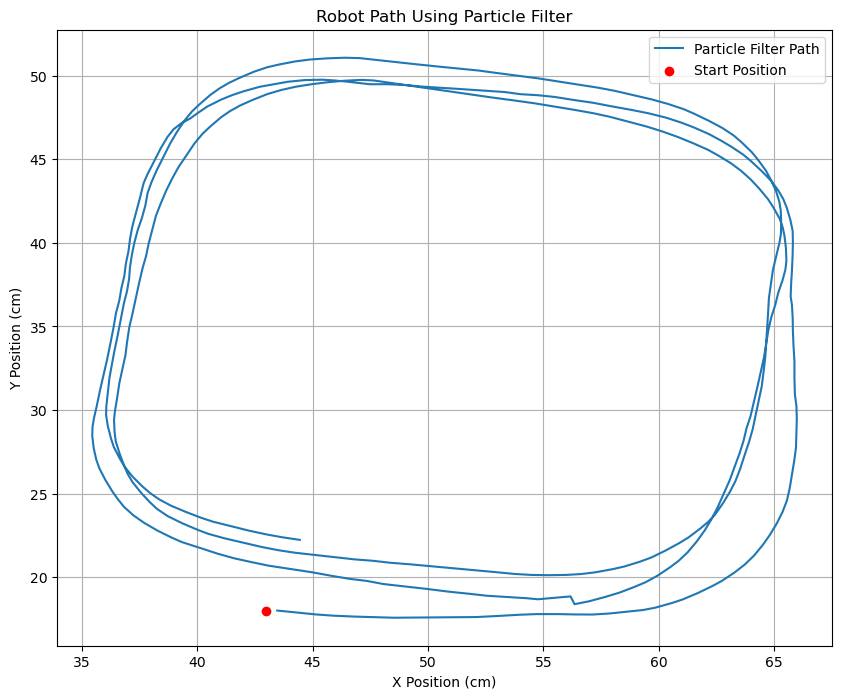

Final Estimated Position: [44.44854168 22.23235434]
Final Heading (Degrees): 350.49579562008057


In [23]:
# Initialize Particle Filter
INITIAL_X = 43
INITIAL_Y = 18
INITIAL_PSI = 0
mu = np.array([INITIAL_X, INITIAL_Y, INITIAL_PSI])
sigma = np.eye(3) * 0.01
NUMBER_OF_PARTICLES = 1000

# Initialize particle distribution
def initialise_particle_distribution(number_of_particles, mu, sigma):
    particles = np.random.multivariate_normal(mu, sigma, number_of_particles)
    return particles

particles = initialise_particle_distribution(NUMBER_OF_PARTICLES, mu, sigma)
weights = np.ones(NUMBER_OF_PARTICLES) / NUMBER_OF_PARTICLES

# Gyroscope Bias and Variance
gyro_bias = 0.187297  # Gyro_z bias from the output of task1b
gyro_noise_variance = 0.075692  # Gyro_z variance from the output of task1b

# Propagate particles
def propagate_particle(particle, dt, velocity, gyro_z):
    dp_x = velocity * np.cos(np.deg2rad(particle[2])) * dt
    dp_y = velocity * np.sin(np.deg2rad(particle[2])) * dt

    # Angular velocity with bias and noise
    dpsi = (gyro_z - gyro_bias + np.random.normal(0, np.sqrt(gyro_noise_variance))) * dt

    px = particle[0] + dp_x
    py = particle[1] + dp_y
    psi = (particle[2] + dpsi) % 360
    return np.array([px, py, psi])

# Compute likelihood
def compute_likelihood(particle, s_x, s_y, dist, phi, phi_sigma, dist_sigma):
    d_pred = np.sqrt((s_x - particle[0])**2 + (s_y - particle[1])**2)
    phi_pred = np.arctan2(s_y - particle[1], s_x - particle[0]) * 180 / np.pi - particle[2]
    phi_pred = (phi_pred + 360) % 360

    likelihood_dist = np.exp(-((dist - d_pred)**2) / (2 * dist_sigma**2))
    likelihood_phi = np.exp(-((phi - phi_pred)**2) / (2 * phi_sigma**2))

    likelihood_dist = max(likelihood_dist, 1e-6)  # Prevent likelihood from being zero
    likelihood_phi = max(likelihood_phi, 1e-6)

    return likelihood_dist * likelihood_phi

# Resample particles
def resample_particles(particles, weights):
    indices = np.random.choice(len(particles), size=len(particles), replace=True, p=weights)
    resampled_particles = particles[indices]
    return resampled_particles

# Filtering loop
#dt = XXX # Calculated above
mu_list = []
#dist_sigma = XXX  # Distance measurement noise, used data from task 5
#phi_sigma = XXX  # Direction angle measurement noise, used data from task 5

for index, row in df_camera_imu_motor.iterrows():
    for i, particle in enumerate(particles):
        # Propagate particle
        particles[i] = propagate_particle(particle, dt, row['velocity'], row['gyro_z'])
        
        # Compute likelihood if measurement data is valid
        if not pd.isna(row['mid_point_x_cm']) and not pd.isna(row['mid_point_y_cm']):
            likelihood = compute_likelihood(
                particles[i], 
                row['mid_point_x_cm'], 
                row['mid_point_y_cm'], 
                row['perceived_distance'], 
                row['perceived_direction'], 
                phi_sigma, 
                dist_sigma
            )
            weights[i] *= likelihood
    
    # Check weight sum
    weight_sum = np.sum(weights)
    if weight_sum == 0 or np.isnan(weight_sum):
        print("Warning: All weights are zero or NaN at index {index}. Resetting weights.")
        weights = np.ones(NUMBER_OF_PARTICLES) / NUMBER_OF_PARTICLES
    else:
        weights /= weight_sum
    
    # Update particles
    mu = np.average(particles, axis=0, weights=weights)
    particles = resample_particles(particles, weights)
    mu_list.append(mu)

# Plot path
mu_array = np.array(mu_list)
plt.figure(figsize=(10, 8))
plt.plot(mu_array[:, 0], mu_array[:, 1], label="Particle Filter Path")
plt.scatter([INITIAL_X], [INITIAL_Y], color="red", label="Start Position")
plt.xlabel("X Position (cm)")
plt.ylabel("Y Position (cm)")
plt.title("Robot Path Using Particle Filter")
plt.legend()
plt.grid(True)
plt.show()

# Output final position
print("Final Estimated Position:", mu_array[-1, :2])
print("Final Heading (Degrees):", mu_array[-1, 2])
